In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hakgyunhong","key":"fa00a5f73a60f1439d8cccfeff32f22b"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d fedesoriano/wind-speed-prediction-dataset

  0% 0.00/71.6k [00:00<?, ?B/s]
100% 71.6k/71.6k [00:00<00:00, 29.4MB/s]


In [6]:
!unzip wind-speed-prediction-dataset.zip
!ls

Archive:  wind-speed-prediction-dataset.zip
  inflating: wind_dataset.csv        
kaggle.json  sample_data  wind_dataset.csv  wind-speed-prediction-dataset.zip


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np

import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [11]:
df=pd.read_csv('/content/wind_dataset.csv')

In [12]:
df.head()

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     6574 non-null   object 
 1   WIND     6574 non-null   float64
 2   IND      6574 non-null   int64  
 3   RAIN     6574 non-null   float64
 4   IND.1    6513 non-null   float64
 5   T.MAX    5953 non-null   float64
 6   IND.2    6513 non-null   float64
 7   T.MIN    5900 non-null   float64
 8   T.MIN.G  6214 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 462.4+ KB


In [14]:
df['DATE']=pd.to_datetime(df['DATE'])

# Visualization

<Axes: xlabel='DATE'>

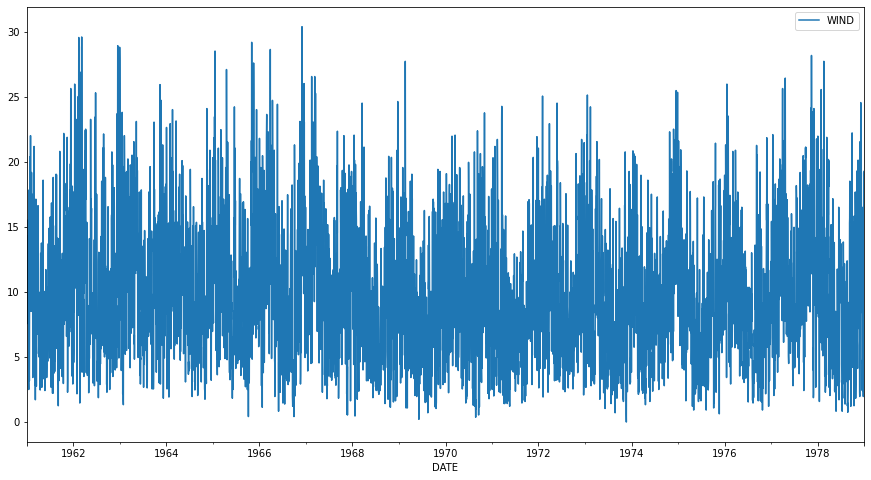

In [15]:
df.plot(x='DATE',y='WIND',figsize=(15,8))

<Axes: >

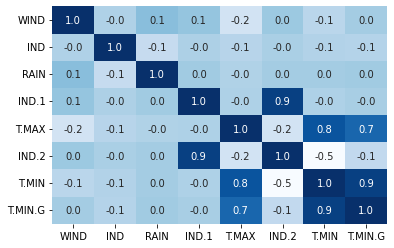

In [16]:
sns.heatmap(df.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

<Axes: >

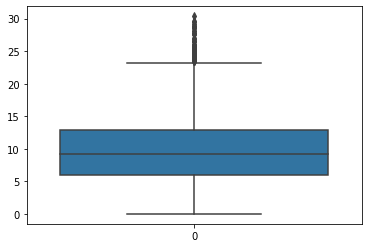

In [17]:
sns.boxplot(df['WIND'])

<Axes: >

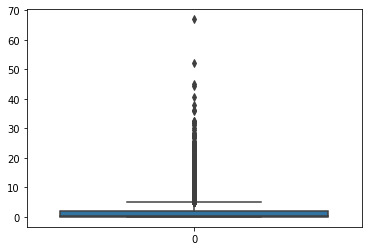

In [18]:
sns.boxplot(df['RAIN'])

<Axes: >

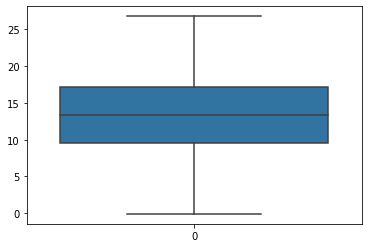

In [19]:
sns.boxplot(df['T.MAX'])

In [20]:
df = df.set_index('DATE')

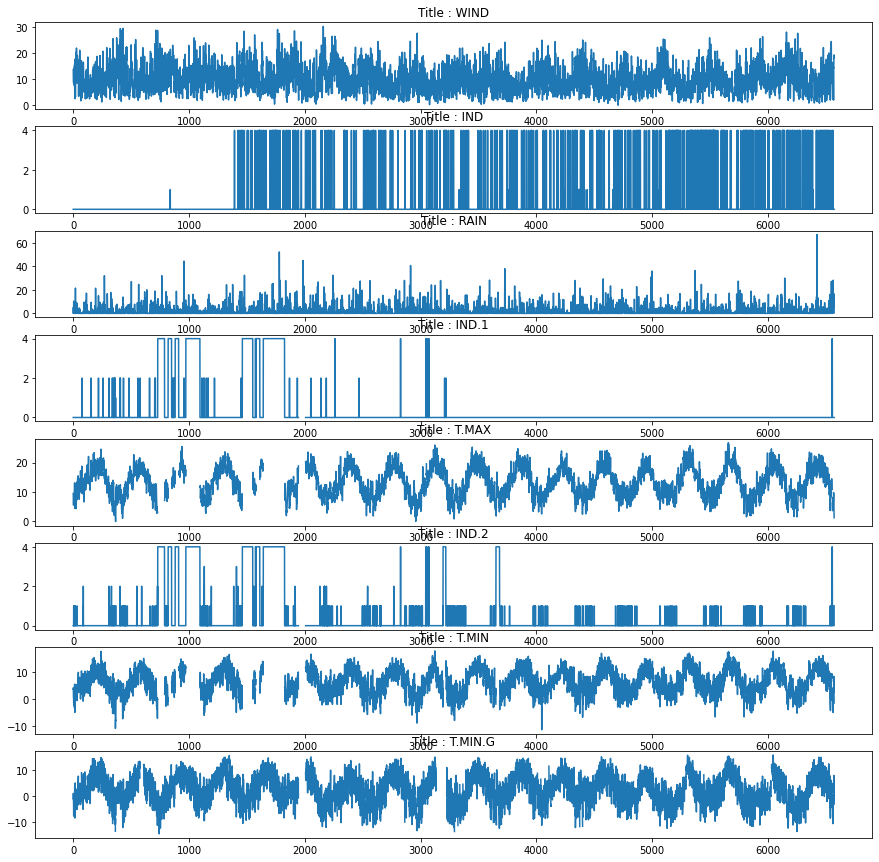

In [23]:
values = df.values
groups =[0,1,2,3,4,5,6,7]
i=1
plt.figure(figsize=(15,15))

for group in groups:
  plt.subplot(len(groups),1,group+1)
  plt.plot(values[:,group])
  plt.title('Title : {}'.format(df.columns[group]))



# Feature Engineering

In [25]:
df.isna().sum()

WIND         0
IND          0
RAIN         0
IND.1       61
T.MAX      621
IND.2       61
T.MIN      674
T.MIN.G    360
dtype: int64

In [29]:
df=df.fillna(0)

In [30]:
df.isna().sum()

WIND       0
IND        0
RAIN       0
IND.1      0
T.MAX      0
IND.2      0
T.MIN      0
T.MIN.G    0
dtype: int64

In [32]:
len(df)

6574

In [ ]:
train_df,test_df = df[:int(len(df)*0.7)], df[int(len(df)*0.7):] 

In [36]:
train=train_df
scalers={}

for i in train_df.columns:
  scaler=MinMaxScaler(feature_range=(-1,1))
  s_s=scaler.fit_transform(train[i].values.reshape(-1,1))
  s_s=np.reshape(s_s,len(s_s))
  scalers['scaler_'+i]=scaler
  train[i]=s_s
test=test_df
for i in train_df.columns:
  scaler=scalers['scaler_'+i]
  s_s=scaler.transform(test[i].values.reshape(-1,1))
  s_s=np.reshape(s_s,len(s_s))
  #scalers['scaler_'+i]=s
  test[i]=s_s

In [108]:
def split_series(series, n_past, n_future):
  X,y=list(),list()
  #X,y = np.array([]),np.array([])
  for window_start in range(len(series)):
    past_end = window_start+n_past
    future_end = past_end+n_future
    if future_end>len(series):
      break
    past,future = series[window_start:past_end,:], series[past_end:future_end,:]
    X.append(past)
    y.append(future)
  return np.array(X),np.array(y)


In [109]:
n_past=10
n_future=5
n_features=8

In [110]:
train.values.shape

(4601, 8)

In [114]:
X_train, y_train = split_series(train.values,n_past,n_future)

In [115]:
X_train.shape

(4587, 10, 8)

In [112]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

In [113]:
X_train.shape

(4587, 10, 8)

In [116]:
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

# Model

In [117]:
# E1D1

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model_e1d1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 8)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        43600       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 5, 100)       0           ['lstm[0][0]']                   
                                                                                              

In [118]:
# E2D2

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

model_e2d2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 8)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 10, 100),    43600       ['input_2[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_3 (LSTM)                  [(None, 100),        80400       ['lstm_2[0][0]']                 
                                 (None, 100),                                               

In [119]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

In [120]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

62/62 [==============================] - 2s 12ms/step


In [121]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [122]:
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,6):
    print("Day ",j,":")
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index]),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index]))
  print()
  print()

WIND
Day  1 :
MAE-E1D1 :  9.566868384150581, MAE-E2D2 :  9.846195445209247
Day  2 :
MAE-E1D1 :  9.550252104508917, MAE-E2D2 :  9.872189582085513
Day  3 :
MAE-E1D1 :  9.542113277777885, MAE-E2D2 :  9.924957289825963
Day  4 :
MAE-E1D1 :  9.549033400998196, MAE-E2D2 :  9.979880153725913
Day  5 :
MAE-E1D1 :  9.573205718581868, MAE-E2D2 :  10.026818632549432


IND
Day  1 :
MAE-E1D1 :  1.206526493087445, MAE-E2D2 :  1.2283791095881726
Day  2 :
MAE-E1D1 :  1.1768235189877279, MAE-E2D2 :  1.2732710326161767
Day  3 :
MAE-E1D1 :  1.192679301078273, MAE-E2D2 :  1.3270665051043795
Day  4 :
MAE-E1D1 :  1.2028799431637165, MAE-E2D2 :  1.3711416004601182
Day  5 :
MAE-E1D1 :  1.2047074403401774, MAE-E2D2 :  1.4048805618088174


RAIN
Day  1 :
MAE-E1D1 :  2.0168073829541084, MAE-E2D2 :  2.335593838877158
Day  2 :
MAE-E1D1 :  2.071853593589701, MAE-E2D2 :  2.424834292405012
Day  3 :
MAE-E1D1 :  2.112912692484456, MAE-E2D2 :  2.485264042100854
Day  4 :
MAE-E1D1 :  2.143057261600486, MAE-E2D2 :  2.51345449